## **Wells map**

**First,** load data from two sources:

* **Oil well inventory.**
* **INEGI's México shape files.**

In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
from matplotlib.lines import Line2D
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from matplotlib.patheffects import withStroke
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.patches import ConnectionPatch

In [2]:
# Load data from well inventory
PATH_INVENTORY = os.path.join('..', '..', 'data', 'oil_intermediate', '02_well_inventory.csv')
df = pd.read_csv(PATH_INVENTORY)
pre99_oil_wells = df.query("preexistent_well == 1")['nombre_pozo'].tolist()
post99_oil_wells = df.query("preexistent_well == 0")['nombre_pozo'].tolist()

In [3]:
# Load data from INEGI for Mexico's map
PATH_SHP = os.path.join('..', '..', 'data', 'oil_shape_files')
mex = gpd.read_file(PATH_SHP+'/inegi_mexico/00ent.shp').to_crs(4326)

In [4]:
# Load oil well shape files
w_ver = gpd.read_file(PATH_SHP+'/veracruz/Zona Veracruz.shp').to_crs(4326)
w_tam = gpd.read_file(PATH_SHP+'/tampico_misantla/Zona Tampico-Misantla.shp').to_crs(4326)
w_sur = gpd.read_file(PATH_SHP+'/sureste/Zona Cuencas del Sureste.shp').to_crs(4326)
w_bur = gpd.read_file(PATH_SHP+'/burgos/Zona Burgos.shp').to_crs(4326)
w_som = gpd.read_file(PATH_SHP+'/aguas_someras/Zona Aguas Someras.shp').to_crs(4326)
w_pro = gpd.read_file(PATH_SHP+'/aguas_profundas/Zona Aguas Profundas.shp').to_crs(4326)

**Second,** divide wells between:

* **Pre-1999.**
* **Post-1999.**

In [5]:
# Pre-1999 wells
w_pre = (
    pd
    .concat(
        [
            w_ver[w_ver['pozo'].isin(pre99_oil_wells)].copy(),
            w_tam[w_tam['pozo'].isin(pre99_oil_wells)].copy(),
            w_sur[w_sur['pozo'].isin(pre99_oil_wells)].copy(),
            w_bur[w_bur['pozo'].isin(pre99_oil_wells)].copy(),
            w_som[w_som['pozo'].isin(pre99_oil_wells)].copy()
        ],
        axis='index'
    )
    .to_crs(4326)
)

# Post-1999 wells
w_post = (
    pd
    .concat(
        [
            w_ver[w_ver['pozo'].isin(post99_oil_wells)].copy(),
            w_tam[w_tam['pozo'].isin(post99_oil_wells)].copy(),
            w_sur[w_sur['pozo'].isin(post99_oil_wells)].copy(),
            w_bur[w_bur['pozo'].isin(post99_oil_wells)].copy(),
            w_som[w_som['pozo'].isin(post99_oil_wells)].copy()
        ],
        axis='index'
    )
    .to_crs(4326)
)

**Third,** define the parameters of the `bbox` (i.e. the region on the map), as well as auxiliary geo-datasets and color parameters

In [6]:
# Identify Gulf states
GULF_STATES = [
    "Tamaulipas", 
    "Veracruz de Ignacio de la Llave", 
    "Tabasco", 
    "Campeche", 
    "Yucatán"
]

# Define the bbox
minx, miny, maxx, maxy = mex[mex['NOMGEO'].isin(GULF_STATES)].total_bounds
pad_x, pad_y = 1.7, 1.2
extent = (minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y)  # (W, E, S, N)

In [7]:
# Neighbor countries
countries_path = shapereader.natural_earth(resolution="10m", category="cultural", name="admin_0_countries")
countries = gpd.read_file(countries_path).to_crs(4326)
neighbors = countries[countries["NAME"].isin(["United States of America", "Guatemala", "Belize"])]

In [8]:
# Wells
wells = {
    'New wells':w_post,
    'Preexistent':w_pre
}

# Style parameters
style = {
    "New wells": {"color": "#71DD3B"},
    "Preexistent": {"color": "#F06611"}
}

**Fourth**, set up parameters for a zoom-in rectangle showing **Cantarell and Ku-Maloob-Zaap wells (Mexico's most productive fileds)**.

In [9]:
# Rectangle coordinates
lon0, lon1, lat0, lat1 = [-93, -91.5, 18, 20]
extent_zoom = [lon0, lon1, lat0, lat1]

In [10]:
# Ku-Maloob-Zaap wells
kmz_fields = ['KU', 'MALOOB', 'ZAAP']
cantarell_fields = ['AKAL', 'NOHOCH', 'CHAC', 'KUTZ', 'IXTOC', 'SIHIL', 'BALAM', 'TAKIN', 'KAMBESAH', 'EK']

# Wells per complex
w_kmz = w_som[w_som['campo'].isin(kmz_fields)].copy()
w_can = w_som[w_som['campo'].isin(cantarell_fields)].copy()

In [11]:
# Wells
wells_rect = {
    'Ku-Maloob-Zaap':w_kmz,
    'Cantarell':w_can
}

# Style parameters
style_rect = {
    "Ku-Maloob-Zaap": {'color':'#3D0BEE'},
    'Cantarell': {'color':"#EE0B47"}
}

**Fifth,** plot the map

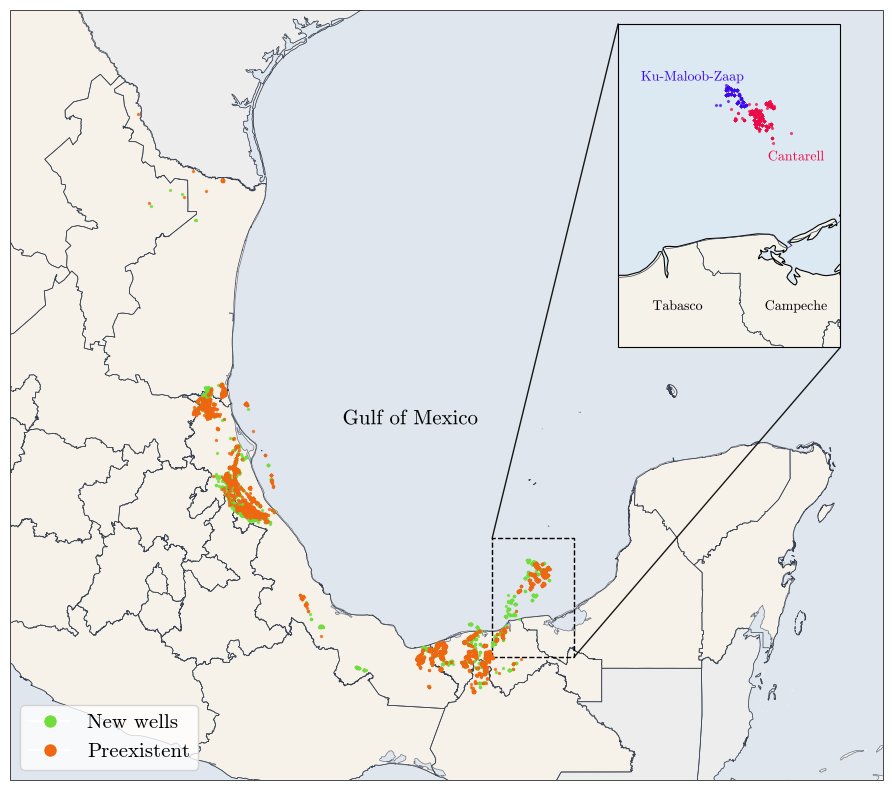

In [12]:
# Figure and axes objects
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.spines["geo"].set_linewidth(0.5)

# Background elements
ax.add_feature(cfeature.OCEAN.with_scale("10m"), facecolor="#DFE6ED", zorder=0)
ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="#F7F2E9", zorder=1)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.5, edgecolor="#6B7280", zorder=2)

# Neighbor countries
neighbors.plot(ax=ax, color="#EDEDED", linewidth=1.2, zorder=2)
neighbors.boundary.plot(ax=ax, color="#374151", linewidth=0.5, zorder=2)

# Mexican states
mex.boundary.plot(ax=ax, color="#374151", linewidth=0.5, zorder=3)

# Wells
for name, gdf in wells.items():
    if gdf.empty:
        continue
    xs = gdf.geometry.x.values
    ys = gdf.geometry.y.values
    ax.scatter(xs, ys, s=2, alpha=0.75, zorder=10, marker='o',
               transform=ccrs.PlateCarree(),
               **style.get(name, {"color": "black"}))
    
# Map legend
handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=style[k]["color"], markersize=10, label=k)
    for k in style.keys()
]
ax.legend(handles=handles, loc="lower left", frameon=True, prop={"family": "cmr10", "size": 15})

# Annotations
ax.text(
        -94.5,22, 
        'Gulf of Mexico', 
        color="black",
        fontfamily="cmr10", 
        fontsize=15, 
        va="center", ha="center",
        path_effects=[withStroke(linewidth=10, foreground="#DFE6ED")]
    )

# Cantarell / Ku-Maloob-Zaap rectangle area on main map
ax.add_patch(Rectangle(
    (lon0, lat0),
    lon1 - lon0,
    lat1 - lat0,
    linewidth=1.0,
    edgecolor="black",
    linestyle="--",
    facecolor="none",
    transform=ccrs.PlateCarree(),
    zorder=4
))

# Zoomed area to show Cantarell / Ku-Maloob-Zaap
axins = inset_axes(
    ax,
    width="32%", height="42%",
    loc="upper right",          # mueve si estorba: "upper right", "lower left", etc.
    borderpad=1.0,
    axes_class=GeoAxes,
    axes_kwargs=dict(projection=ccrs.PlateCarree())   # <-- correcto (no map_projection)
)
axins.set_extent(extent_zoom, crs=ccrs.PlateCarree())

# Background elements
axins.add_feature(cfeature.LAND.with_scale("10m"), facecolor="#F5F2EA", zorder=0)
axins.add_feature(cfeature.OCEAN.with_scale("10m"), facecolor="#DCE8F2", zorder=0)
axins.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.8, zorder=2)
mex.boundary.plot(ax=axins, color="#374151", linewidth=0.5, zorder=3)

# Wells in zoom rectangle
for name, gdf in wells_rect.items():
    if gdf.empty:
        continue
    xs = gdf.geometry.x.values
    ys = gdf.geometry.y.values
    axins.scatter(xs, ys, s=2, alpha=0.75, zorder=10, marker='x',
               transform=ccrs.PlateCarree(),
               **style_rect.get(name, {"color": "black"}))

# State labels
axins.text(
        -92.6,18.25, 
        'Tabasco', 
        color="black",
        fontfamily="cmr10", 
        fontsize=10, 
        va="center", ha="center",
        path_effects=[withStroke(linewidth=10, foreground="#F7F2E9")]
    )

# State labels
axins.text(
        -91.8,18.25, 
        'Campeche', 
        color="black",
        fontfamily="cmr10", 
        fontsize=10, 
        va="center", ha="center",
        path_effects=[withStroke(linewidth=10, foreground="#F7F2E9")]
    )

# Oil fields labels
axins.text(
        -91.8,19.175, 
        'Cantarell', 
        color=style_rect['Cantarell']['color'],
        fontfamily="cmr10", 
        fontsize=10,
        fontweight='bold',
        va="center", ha="center",
        path_effects=[withStroke(linewidth=10, foreground="#DCE8F2")]
    )

axins.text(
        -92.5,19.67, 
        'Ku-Maloob-Zaap', 
        color=style_rect['Ku-Maloob-Zaap']['color'],
        fontfamily="cmr10", 
        fontsize=10,
        fontweight='bold',
        va="center", ha="center",
        path_effects=[withStroke(linewidth=10, foreground="#DCE8F2")]
    )

# Connecting lines
# Rectangle corners
rect_ll = (lon0, lat1)  # lower-left
rect_ur = (lon1, lat0)  # upper-right

# Inset corners
ins_ll = (0, 1)
ins_ur = (1, 0)

# Line 1
con1 = ConnectionPatch(
    xyA=ins_ll, coordsA=axins.transAxes,   # inset axes fraction
    xyB=rect_ll, coordsB=ccrs.PlateCarree()._as_mpl_transform(ax),  # mapa en lon/lat
    color="black", linewidth=1.0, alpha=0.9, zorder=20
)

# Line 2
con2 = ConnectionPatch(
    xyA=ins_ur, coordsA=axins.transAxes,
    xyB=rect_ur, coordsB=ccrs.PlateCarree()._as_mpl_transform(ax),
    color="black", linewidth=1.0, alpha=0.9, zorder=20
)

fig.add_artist(con1)
fig.add_artist(con2)

# Show
plt.show()